# Time series Analysis

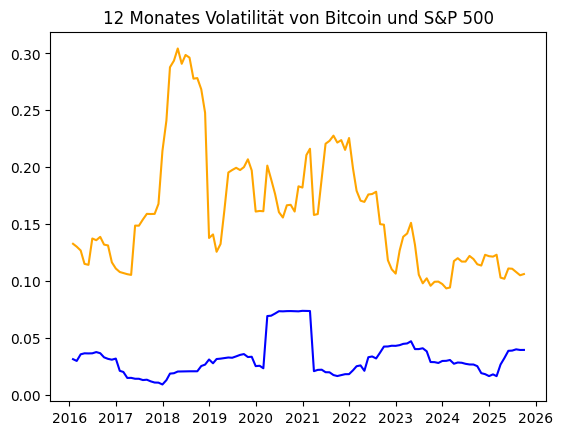

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

market_data = pd.read_csv("../processed/market_data.csv", parse_dates=["Date"])
market_data = market_data.set_index("Date").sort_index()

window = 12 # n months
roll__volatility = market_data[["btc_logret", "sp500_logret"]].rolling(window).std()

plt.figure()
plt.plot(roll__volatility.index, roll__volatility["btc_logret"], label="Volatilität (12M) - Bitcoin", color="orange")
plt.plot(roll__volatility.index, roll__volatility["sp500_logret"], label="Volatilität (12M) - S&P 500", color="blue")
plt.title("12 Monates Volatilität von Bitcoin und S&P 500")
plt.show()
plt.close()

## ADF & KPSS Stationarity

In [2]:
from statsmodels.tsa.stattools import adfuller, kpss


def adf_test(x, name):
    x = x.dropna()
    stat, p, _, _, critical, _ = adfuller(x)
    return {
        "test": "ADF",
        "series": name,
        "stat": stat,
        "p": p,
        "1%": critical["1%"], 
        "5%": critical["5%"], 
        "10%": critical["10%"],
    }


def kpss_test(x, name):
    x = x.dropna()
    stat, p, _, critical = kpss(x, regression="c")
    return {
        "test": "KPSS",
        "series": name,
        "stat": stat,
        "p": p,
        "1%": critical["1%"], 
        "5%": critical["5%"], 
        "10%": critical["10%"],
    }


results = []
for col in market_data.columns:
    results.append(adf_test(market_data[col], col))
    # KPSS can fail for some series
    try:
        results.append(kpss_test(market_data[col], col))
    except Exception as e:
        results.append({"test": "KPSS", "series": col, "stat": None,
                       "p": None, "1%": None, "5%": None, "10%": None})


results_df = pd.DataFrame(results).round(4)
results_df

/var/folders/gw/25jjny9j4w12rcmml4055qxh0000gn/T/ipykernel_42113/2796595938.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, _, critical = kpss(x, regression="c")
/var/folders/gw/25jjny9j4w12rcmml4055qxh0000gn/T/ipykernel_42113/2796595938.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, _, critical = kpss(x, regression="c")
/var/folders/gw/25jjny9j4w12rcmml4055qxh0000gn/T/ipykernel_42113/2796595938.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, _, critical = kpss(x, regression="c")
/var/folders/gw/25jjny9j4w12rcmml4055qxh0000gn/T/ipykernel_42113/2796595938.py:20: InterpolationWarning

,test,series,stat,p,1%,5%,10%
0,ADF,btc_logret,-7.6258,0.0000,-3.4829,-2.8846,-2.5791
1,KPSS,btc_logret,0.1136,0.1000,0.7390,0.4630,0.3470
2,ADF,sp500_logret,-10.1010,0.0000,-3.4829,-2.8846,-2.5791
3,KPSS,sp500_logret,0.0909,0.1000,0.7390,0.4630,0.3470
4,ADF,usdindex_logret,-7.2760,0.0000,-3.4838,-2.8850,-2.5793
5,KPSS,usdindex_logret,0.0807,0.1000,0.7390,0.4630,0.3470
6,ADF,inflation,-1.9888,0.2915,-3.4856,-2.8857,-2.5797
7,KPSS,inflation,0.4836,0.0454,0.7390,0.4630,0.3470
8,ADF,m2_growth,-4.0187,0.0013,-3.4838,-2.8850,-2.5793
9,KPSS,m2_growth,0.2510,0.1000,0.7390,0.4630,0.3470


## BTC returns 

In [12]:
from pathlib import Path
import matplotlib as mpl
mpl.use("Agg")  # prevents any GUI/TeX backend weirdness

import matplotlib.pyplot as plt

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Open Sans"],
    "pdf.fonttype": 42,     # embed TrueType fonts
    "ps.fonttype": 42,
})

FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 4))
market_data["btc_logret"].plot(ax=ax)

ax.set_title("Monatliche Renditen von Bitcoin (2015–2025)")
ax.set_xlabel("Datum")
ax.set_ylabel("Log-Rendite")
ax.axhline(0, color="black", linewidth=0.8)

fig.tight_layout()
fig.savefig(FIG_DIR / "btc_returns.pdf")   # works without LaTeX
plt.close(fig)


## Geldpolitik und Inflation

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# Left axis: Fed Funds Rate
market_data["fedfunds"].plot(ax=ax1, color="tab:blue", linewidth=2)
ax1.set_ylabel("Fed Funds Rate (%)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right axis: Inflation
ax2 = ax1.twinx()
market_data["inflation"].plot(ax=ax2, color="tab:red", linewidth=2)
ax2.set_ylabel("Monatliche Inflation", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout
ax1.set_title("Geldpolitisches Umfeld: Zinsen und Inflation")
fig.tight_layout()

# Save (thesis-safe)
fig.savefig(FIG_DIR / "fedfunds_inflation.pdf")
plt.close(fig)


## BTC vs. S&P-500

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

market_data[["btc_logret", "sp500_logret"]].plot(
    ax=ax,
    linewidth=2
)

ax.set_title("Bitcoin vs. S&P 500 Renditen")
ax.set_ylabel("Log-Rendite")
ax.axhline(0, color="black", linewidth=0.8)

fig.tight_layout()
fig.savefig(FIG_DIR / "btc_vs_sp500_returns.pdf")
plt.close(fig)
